# Tasca M7 T01

Como en el ejercicio de modelos de regresión realizamos comparaciones entre modelos utilizando para ello diferentes tipos de preprocesamiento en esta ocasión nos concentraremos en estudiar cada uno de los modelos por separado empleando un data set con un preprocesamiento básico (estandarización y balanceo de las clases). Adicionalmente, en cada uno de los modelos realizaremos un estudio detallado de sus hiperparámetros y métricas de evaluación. 

Finalmente, a manera de conclusión haremos una comparación aplicando los modelos con el dataset sin preprocesar y con el dataset preprocesado para determinar la eficacia del preprocesado,

Así, el ejercicio lo dividiremos en tres secciones: 
- Importación, descripción y preprocesamiento del dataset 
- Modelos: 
1. Regresión Logística
2. SVM
3. K-Nearest Neigbors 
4. Decision Trees y Random Forest
- comparación entre la utilización de los modelos con el dataset no procesado, con el dataset procesado y con los modelos afinados.


# Importación, descripción y preprocesamiento del dataset

In [1]:
#importamos las librerías necesarias para este ejercicio
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [2]:
#importamos el dataset e incluimos los nombres de las columnas contenidos en el archivo .txt
df=pd.read_csv('wineData.txt', sep=',',
               names=["Class","Alcohol","Malic","Ash","Alkalinity","Magnesium","Phenols","Flavanoids","Nonflav","Proanthocyan","Color","Hue","OD280","Proline"])

In [3]:
#echamos un primer vistazo al dataset con el método head
df.head()

,Class,Alcohol,Malic,Ash,Alkalinity,Magnesium,Phenols,Flavanoids,Nonflav,Proanthocyan,Color,Hue,OD280,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


- Observamos un dataset compuesto exclusivamente por columnas númericas (tres de ellas int64). 
- Las escalas de cada una de las columnas son diferentes.
- La columna "Class" está organizada por clases
- Por los datos añadidos en el archivo .txt podemos afirmar que la variable dependiente está contenida en la columna "Class". El resto de columnas las asumimos como independientes. 

Es decir que el objetivo de nuestros ejercicios será clasificar nuevos datos a partir de las clases contenidas en la columna "Class".

In [4]:
#confirmamos los types de las columnas mediante el método info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Class         178 non-null    int64  
 1   Alcohol       178 non-null    float64
 2   Malic         178 non-null    float64
 3   Ash           178 non-null    float64
 4   Alkalinity    178 non-null    float64
 5   Magnesium     178 non-null    int64  
 6   Phenols       178 non-null    float64
 7   Flavanoids    178 non-null    float64
 8   Nonflav       178 non-null    float64
 9   Proanthocyan  178 non-null    float64
 10  Color         178 non-null    float64
 11  Hue           178 non-null    float64
 12  OD280         178 non-null    float64
 13  Proline       178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [5]:
#revisamos las dimensiones del dataset
rows, cols = df.shape
print("El dataframe tiene", rows, "filas y", cols, "variables.\n")

El dataframe tiene 178 filas y 14 variables.



Teniendo en cuenta el tamaño del dataset, desde ya podemos asumir que no existan el número suficiente de datos para que los modelos funcionen de manera adecuada presentando unos resultados no del todo satisfactorios. 

In [6]:
#investigamos si el dataset tiene nulos
nulos = df.isnull().sum()

if nulos.all() == 0: 
    print("El dataset no tiene nulos")
else: 
    print("El dataset tiene nulos")

El dataset no tiene nulos


In [7]:
#realizamos una descripción estadística básica del data set con el metodo describe
df.describe()

,Class,Alcohol,Malic,Ash,Alkalinity,Magnesium,Phenols,Flavanoids,Nonflav,Proanthocyan,Color,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


A través del describe podemos observar:
- Las columnas "Malic", "Magnesium", "Flavanoids",  "Color" y "Proline" presentan skews hacia la derecha. Lo sabemos observando la gran distancia existente entre su quartil 75% y el valor máximo
- No existen columnas con un skew pronunciado hacia la izquierda
- El resto de columnas parecen tener distribuciones normales


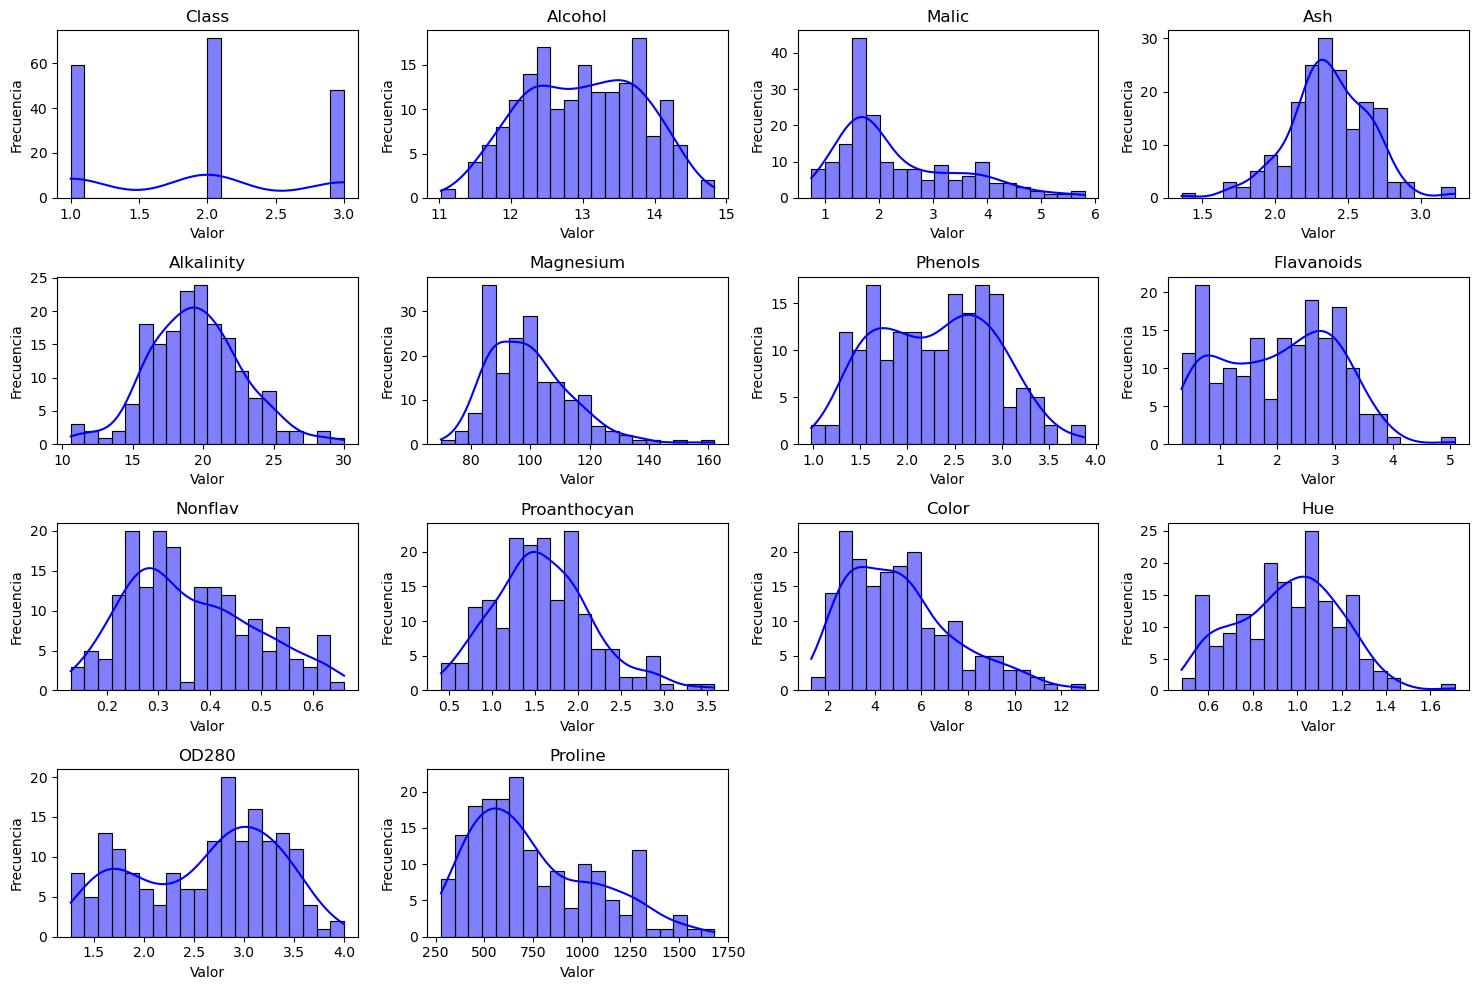

In [8]:
#creamos la figura
plt.figure(figsize=(15, 10))

#iteramos sobre cada columna en X_train y creamos un histograma
for i, column in enumerate(df.columns):
    plt.subplot(4, 4, i + 1) 
    sns.histplot(df[column], bins=20, kde=True, color='blue', edgecolor='black')
    plt.title(column)
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Con los histogramas podemos comprobar que:
- Las columnas "Malic", "Magnesium", "Flavanoids",  "Color" y "Proline" se escoran hacia la derecha. 
- No hay ninguna columna que tenga un skew hacia la izquierda
- Las columnas "Alcohol", "Ash", "Alkalinity", "Proanthocyan" y "Hue" tienen distribuciones normales. 

Finalmente, podemos observar que la variable "Class" tiene 3 valores -cada uno representa una clase-. Al ser este un ejercicio de clasificación describiremos las 3 clases y luego averiguaremos que peso relativo tienen las variables dependientes en cada una de las clases. Añadimos que al existir 3 clases utilizaremos métodos de clasificación multi-clase y no binarios 

Class
2    71
1    59
3    48
Name: count, dtype: int64


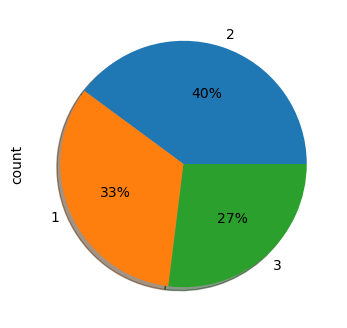

In [9]:
#visualizamos la distribución de la variable "Class"
conteo_clase = df['Class'].value_counts()
explode = (0, 0.1, 0)
conteo_clase.plot(kind='pie',autopct='%.0f%%', shadow=True, figsize=(4,4), radius=1.0)

print(conteo_clase)

Los resultados del conteo nos informan que hay cierto desbalance en la cantidad de observaciones pertenecientes a cada clase. Este desbalanceo puede influir en la capacidad clasificatoria de los modelos de ML por lo cual lo corregiremos en el preprocesado utilizando SMOTE (técnica de remuestreo). En el preprocesado, además, dividiremos el dataset en conjuntos de entrenamiento de prueba y lo estandarizaremos. 

In [10]:
#separamos del dataset original las variables dependientes y las independientes
X = df.drop("Class", axis = 1)
y = df["Class"]

In [11]:
#dividimos el dataset en conjuntos de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#describimos las dimensiones del conjunto de entrenamiento y de prueba
rows_train, cols_train = X_train.shape
rows_test, cols_test = X_test.shape
print("El conjunto de entrenamiento tiene", rows_train, "filas y", cols_train, "variables.\n")
print("El conjunto de prueba tiene", rows_test, "filas y", cols_test, "variables.\n")

El conjunto de entrenamiento tiene 142 filas y 13 variables.

El conjunto de prueba tiene 36 filas y 13 variables.



In [12]:
#determinamos la distribución original en el conjunto de entrenamiento
print("Distribución original de clases en el conjunto de entrenamiento:", Counter(y_train))

#aplicamos la técnica de remuestreo en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#imprimimos la nueva distribución de clases
print("Nueva distribución de clases después de SMOTE:", Counter(y_resampled))


Distribución original de clases en el conjunto de entrenamiento: Counter({2: 57, 1: 45, 3: 40})
Nueva distribución de clases después de SMOTE: Counter({3: 57, 2: 57, 1: 57})


In [13]:
#instanciamos StandardScaler
scaler = StandardScaler()

#estandarizamos el conjunto de entrenamiento resampleado
X_train_standardized = scaler.fit_transform(X_resampled)

#aplicamos la misma estandarización al conjunto de prueba
X_test_standardized = scaler.transform(X_test)

Después del preprocesado utilizamos el método xgboost para averiguar el peso de cada variable en la clasificación de las tres clases 

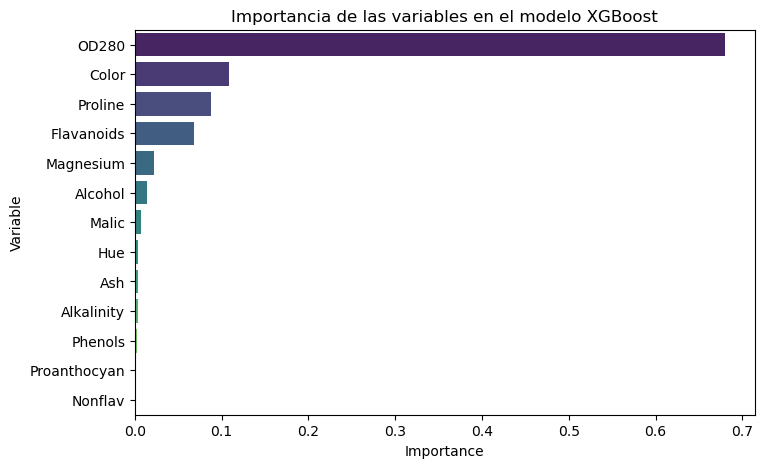

In [14]:
#ajustamos las clases para que no sean [1,2,3] sino [0,1,2] y las pueda reconocer el modelo
y_resampled_adjusted = y_resampled - 1
y_test_adjusted = y_test - 1

#instanciamos como clasificador XGBoost e incluimos parámetros para que funcione como multiclase
xg_cl = xgb.XGBClassifier(objective='multi:softmax', num_class=3, seed=42)

#entrenamos el modelo
xg_cl.fit(X_train_standardized, y_resampled_adjusted)

#obtenemos la importancia de las variables
feature_importances = xg_cl.feature_importances_

#creamos un DataFrame para mostrar las importancias de las variables
feature_importance_df = pd.DataFrame({'Variable': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Variable', data=feature_importance_df, palette='viridis')
plt.title('Importancia de las variables en el modelo XGBoost')
plt.show()

Según los resultados del xgboost, las tres variables que tienen más peso en la clasificación de las clases de vino son: "OD280", "Color" y "Proline".

En la siguiente sección, Después de haber descrito y preprocesado nuestro dataset, aplicaremos cinco modelos de clasificación de ML. En cada uno de ellos analizaremos sus especificades e intentaremos ajustarlos para que entreguen los mejores resultados posibles 

# Modelos de Clasificación 

Antes de comenzar a estudiar los modelos, realizaremos un comentario sobre los criterios de evaluación en los métodos de clasificación y haremos una comparación preliminar entre los modelos que más adelante desarrollaremos a profundidad

## Evaluación en modelos de clasificación: 

Los conceptos básicos para comprender la evaluación en métodos de clasificación tienen que ver con los errores tipo I (falsos positivos) y errores tipo II (falsos negativos).

En síntesis, un modelo de clasificación puede retornar cuatro resultados: 
- True positive (tp): los datos positivos que han sido correctamente clasificados como positivos
- True negatives (tn): los datos negativos que han sido correctamente clasificados como negativos
- False positive (fp): los datos positivos que han sido clasificados como negativos
- False negative (fn): los datos negativos que han sido clasificados como positivos

La evaluación de estos criterios nos permiten establecer los siguientes indicadores: 
- accuracy (es el que más se utiliza, pero no siempre es el más adecuado): suma de las predicciones positivas tp+tn / tp+tn+fp+fn
- precision: tp / tp + fp
- recall: tp / tp + fn
- f1 - score: 2 * (precision * recall / precision + recall) 

Los reportes de clasificación imprimen los resultados de cada uno de estos indicadores por cada una de las clases a clasificar, aunque la accuracy se computa como una evaluación general del modelo. 

La visualización de la matriz de confusión nos permite tener una representación gráfica de tp, tn, fp, y fn por cada una de las clases. 

Aunque no lo utilizaremos en este caso, pues evalua modelos de clasificación binaria, también es necesario mencionar el indicador ROC AUC que puntua los modelos de acuerdo a tp y fp (1 y 0).

Después de esta breve introducción, realizaremos un ejercicio preliminar de evaluación (utilizando accuracy) conjunta de todos los modelos que pretendemos estudiar -configurados en su manera más básica- y extraeremos algunas conclusiones preliminares.

In [15]:
SEED = 42
#instanciamos los modelos individuales
lr = LogisticRegression(random_state=SEED)
knn = KNN()
dt = DecisionTreeClassifier(random_state=SEED)
svm = SVC(random_state=SEED)

#definimos una lista que incluye tuplas de (nombre del clasificador, modelo instanciado)
clasificadores = [('Logistic Regression', lr),
                  ('SVM', svm),
                  ('K Nearest Neighbours', knn), 
                  ('Decision Tree', dt),
                 ]

#iteramos por cada modelo para obtener la métrica de evaluación 
for clf_name, clf in clasificadores:
    clf.fit(X_train_standardized, y_resampled_adjusted)
    y_pred = clf.predict(X_test_standardized)
    accuracy = accuracy_score(y_test_adjusted, y_pred)
    print('{:s} : {:.3f}'.format(clf_name, accuracy))

Logistic Regression : 1.000
SVM : 1.000
K Nearest Neighbours : 0.944
Decision Tree : 0.917


Podemos concluir preliminarmente que: 
- Los modelos de clasificación linear (lr y svm) tienen una accuracy de 1 sobre los conjuntos de prueba. En las condiciones específicas de este ejercicio (es decir, un data set muy pequeño) este resultado puede indicarnos no la gran calidad del modelo sino la presencia de overfitting. Esto lo podremos comprobar corriendo un evaluación cross-validation en estos dos modelos. 
- Los modelos no lineares puede que se ajusten más a nuestro data set. Añadiremos algunos hiperparámetros para intentar mejorar sus rendimiento. 

## Modelos de clasificación lineal 1: Regresión Logística 

Accuracy de la regresión logística: 1.0

Informe de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



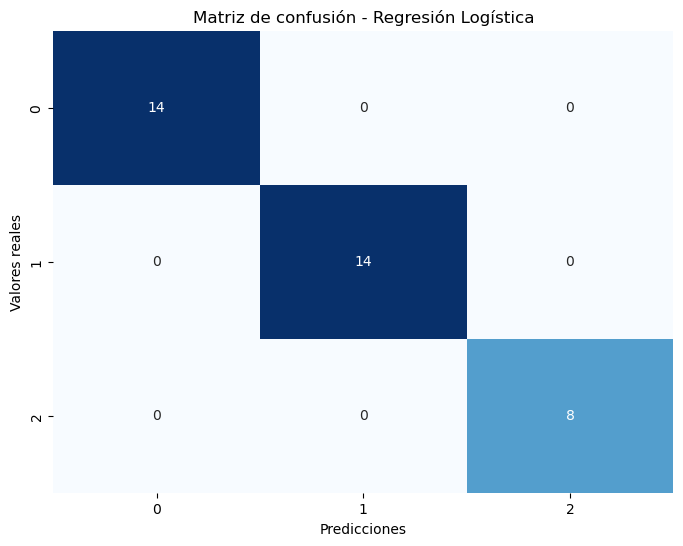

In [16]:
#instanciamos el modelo de regresión logística
logreg = LogisticRegression(random_state=SEED, max_iter=1000)

#entrenamos el modelo 
logreg.fit(X_train_standardized, y_resampled_adjusted)

#realizamos predicciones con el conjunto de prueba
preds_logreg = logreg.predict(X_test_standardized)

#calculamos la accuracy
accuracy_logreg = accuracy_score(y_test_adjusted, preds_logreg)
print("Accuracy de la regresión logística:", accuracy_logreg)

#imprimimos el informe de clasificación
print("\nInforme de clasificación:\n", classification_report(y_test_adjusted, preds_logreg))

#visualizamos la matriz de confusión
conf_matrix_logreg = confusion_matrix(y_test_adjusted, preds_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=logreg.classes_, yticklabels=logreg.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión - Regresión Logística')
plt.show()

Como lo mencionamos anteriormente los resultados de este modelo nos hacen pensar que sufre de overfitting. Aunque son varias las estrategias para combatir el overfitting (por ejemplo, utilizar un dataset más grande) aquí optaremos simplemente por realizar una cross-validations para evaluar el modelo en diferentes particiones de datos. Además añadiremos algo de regularización "C=0.01" para penalizar los coeficientes más grandes (en este caso, como lo vimos antes, tenemos una variable ""OD280" que asume todo el pero de la regresión).

Evaluaremos el modelo utilizando el indicador "accuracy". Lamentablemente, al ser una cross-validation no podremos obtener la matriz de confusión y el informe de clasificación (podríamos obtenerlos por cada fold pero es demasiado engorroso). 

In [24]:
#instanciamos el modelo y añadimos la regularización
logreg = LogisticRegression(C=0.01, random_state=SEED)

#realizamos la validación cruzada con 10 pliegues
accuracy_scores_logreg = cross_val_score(logreg, X_train_standardized, y_resampled_adjusted, cv=10, scoring='accuracy')

#imprimimos la puntuación de cada pliegue
print("Puntuaciones de la validación cruzada:", accuracy_scores_logreg)

#imprimimos el promedio de la puntuación y su desviación estándar
print("accuracy media de la validación cruzada:", accuracy_scores_logreg.mean())
print("Desviación estándar de la validación cruzada:", accuracy_scores_logreg.std())

Puntuaciones de la validación cruzada: [0.94444444 1.         0.94117647 1.         0.88235294 1.
 1.         0.94117647 1.         1.        ]
accuracy media de la validación cruzada: 0.9709150326797384
Desviación estándar de la validación cruzada: 0.039227939262240316


Podemos observar que en algunos folios tuvieron evaluaciones de 1, aunque los resultados del resto hicieron que la evaluación media disminuyera un poco. Al parecer nuestra estrategia para evitar el overfitting funcionó y ahora tenemos un modelo mucho más ajustado, a pesar del tamaño del dataset. 

## Modelos de clasificación lineal 2: Support Vector Machines

Este algortimo lineal utiliza para ejecutar la clasificación los Support Vectors que son los datos mal clasificados y los que se encuentran muy cerca de la línea de decisión. 

Además, este algoritmo por definición utiliza la regularización L2 (Ridge) y la función Hidge que minimiza la pérdida de los predicciones correctas. 

Este método, al igual que la regresión logística, tiene una evaluación de 1, lo que nos lleva a pensar que tiene overfitting. Por tal razón, correremos el método utilizando cross-validation e incluyendo los siguientes hiperparámetros. 
- C: fuerza de la regularización (un valor mayor significa una regularización más débil)
- Kernel: tipo de función matemática según la naturaleza de los datos (lineales, polinómicos)
- gamma: determina la flexibilidad de la línea de decisión

In [25]:
#instanciamos el modelo
svm = SVC(random_state=SEED)

#creamos el diccionario con los parámetros
param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale', 'auto', 0.1, 1, 10]}

#utilizamos GridSearch para buscar los mejores valores de los hiperparámetros
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_standardized, y_resampled_adjusted)

#obtenemos los mejores hiperparámetros 
best_params = grid_search.best_params_
print("Mejores parámetros:", best_params)

#creamos un clasificador SVM con los mejores parámetros
best_svm = SVC(C=best_params['C'], kernel=best_params['kernel'], gamma=best_params['gamma'])

#evaluamos el rendimiento del modelo con cross validation 
accuracy_scores_SVM = cross_val_score(best_svm, X_train_standardized, y_resampled_adjusted, cv=5, scoring='accuracy')

#imprimimos la puntuación de cada pliegue
print("Puntuaciones de precisión en cada pliegue:", accuracy_scores_SVM)

#imprimimos el promedio de la puntuación y su desviación estándar
print("Precisión media:", accuracy_scores_SVM.mean())
print("Desviación estándar de la precisión:", accuracy_scores_SVM.std())

Mejores parámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Puntuaciones de precisión en cada pliegue: [1.         1.         1.         0.97058824 1.        ]
Precisión media: 0.9941176470588236
Desviación estándar de la precisión: 0.011764705882352944


La utilización de la validación cruzada y de la búsqueda en cuadrilla para obtener los mejores valores para cada hiperparámetro nos permite desarrollar un modelo que al mismo tiempo que evita el overfitting presenta resultados muy satisfactorios.

## Modelos de clasificación: K Nearest Neighbours

KNN clasifica los nuevos datos basado en la proximidad de los datos existentes. Para dicha operación calcula la distancia entre los datapoints y establece la clase del nuevo dato según la mayoría de datos que están a su alrededor.

En este apartado: 
- estableceremos utilizando el método del codo cuál es el mejor número K, es decir, el número de datos alrededor del nuevo datos que se tendrán en cuenta para hacer la clasificación.
- aplicaremos el modelo utilizando algunos de sus hiperparámetros

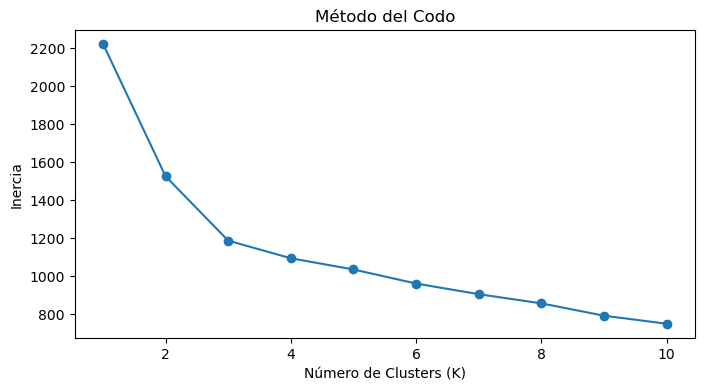

In [19]:
#establecemos un rango de valores de k y una creamos una lista vacía
k_values = range(1, 11)
inertia_values = []

#iteramos el modelo y añadimos a la lista vacía los valores de inercia (sumas cuadráticas dentro de los clusters)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_standardized)
    inertia_values.append(kmeans.inertia_)

#graficamos el método del codo trazando una línea
plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.show()

A partir de la gráfica podemos decir que el mejor valor de K es 4, pues es desde allí que la inercia deja de disminuir rápidamente. Ahora corramos el método con los siguientes hiperparámetros: 
- Weights: determina cómo se ponderan los votos de los vecinos más cercanos al realizar una clasificación. Puede ser "uniform", es decir que todos los vecinos tienen el mismo valor, o "distance" que los vecinos más cercanos tienen más valor
- p: controla cómo se calcula la distancia entre los valores. Puede ser 1 (manhattan) o 2 (euclidiana)

In [26]:
#instanciamos el modelo
knn = KNN(n_neighbors = 4)

#creamos el diccionario con los parámetros
param_grid = {'weights': ['uniform', 'distance'],
              'p': [1, 2] }

#utilizamos GridSearch para buscar los mejores valores de los hiperparámetros
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_standardized, y_resampled_adjusted)

#obtenemos los mejores hiperparámetros 
best_params = grid_search.best_params_
print("Mejores parámetros:", best_params)

#creamos un clasificador KNN con los mejores parámetros
best_knn = KNN(weights=best_params['weights'], p=best_params['p'])

#evaluamos el rendimiento del modelo con cross validation 
accuracy_scores_KNN = cross_val_score(best_knn, X_train_standardized, y_resampled_adjusted, cv=5, scoring='accuracy')

#imprimimos la puntuación de cada pliegue
print("Puntuaciones de precisión en cada pliegue:", accuracy_scores_KNN)

#imprimimos el promedio de la puntuación y su desviación estándar
print("Precisión media:", accuracy_scores_KNN.mean())
print("Desviación estándar de la precisión:", accuracy_scores_KNN.std())

Mejores parámetros: {'p': 1, 'weights': 'distance'}
Puntuaciones de precisión en cada pliegue: [1.         0.97058824 0.94117647 0.97058824 0.97058824]
Precisión media: 0.9705882352941178
Desviación estándar de la precisión: 0.018601633295108118


Gracias a los hiperparámetros y a la escogencia del mejor número K aumentamos la accuracy del modelo de 0.944 a 0.970

## Modelos de clasificación: Decision Trees - AdaBoost

Al ejecutar los modelos sin ajustes la evaluación del Decisión Trees (0.917) fue la mejor. Esto tiene que ver con que los árboles de decisión son "weak learners" y por esta razón suelen combinarse varios árboles para robustecer sus predicciones. 

Aquí utilizaremos AdaBoost que es un método de ensamble que utiliza muchos predictores (muchos árboles) haciendo que cada uno de ellos aprenda de los erorres de su predecesor. 

Ajustaremos los siguientes hiperparámetros: 
n_estimators: la cantidad de árboles que entrenaremos
learning_rate: controla la contribución de cada predictor con el modelo final

In [27]:
#instanciamos el clasificador base (en este caso un árbol de decisión)
dt = DecisionTreeClassifier(random_state=SEED)

#instanciamos el modelo AdaBoost
adb_clf = AdaBoostClassifier(dt)

#creamos el diccionario con los hiperparámetros a explorar
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

#utilizamos GridSearch para buscar los mejores valores de los hiperparámetros
grid_search = GridSearchCV(estimator=adb_clf, param_grid=param_grid, scoring='accuracy', cv=5)

#ajustamos el modelo con el GridSearch
grid_search.fit(X_train_standardized, y_resampled_adjusted)

#imprimimos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

#imprimimos los resultados del mejor modelo
best_model = grid_search.best_estimator_
accuracy_dt = best_model.score(X_test_standardized, y_test_adjusted)
print("Precisión en el conjunto de prueba:", accuracy)

Mejores hiperparámetros: {'learning_rate': 1.0, 'n_estimators': 50}
Precisión en el conjunto de prueba: 0.9166666666666666


Incluso utilizando la búsqueda de cuadrícula y ajustando los hiperparámetros los resultados del modelo no son del todo satisfactorios, incluso no mejoran la evaluación del modelo preliminar. Esto quiere decir que este algoritmo no es adecuado para nuestro data set o, de nuevo, que nuestro data set es demasiado pequeño para producir mejores resultados. 

## Comparación entre los modelos con el data set sin preprocesar y con el data set preprocesado

In [22]:
SEED = 42
#instanciamos los modelos individuales
lr = LogisticRegression(random_state=SEED)
knn = KNN()
dt = DecisionTreeClassifier(random_state=SEED)
svm = SVC(random_state=SEED)

#definimos una lista que incluye tuplas de (nombre del clasificador, modelo instanciado)
clasificadores = [('Logistic Regression', lr),
                  ('SVM', svm),
                  ('K Nearest Neighbours', knn), 
                  ('Decision Tree', dt),
                 ]

#iteramos por cada modelo sin preprocesar para obtener la métrica de evaluación 
for clf_name, clf in clasificadores:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('{:s} : {:.3f}'.format(clf_name, accuracy))

Logistic Regression : 0.972
SVM : 0.806
K Nearest Neighbours : 0.722
Decision Tree : 0.944


In [23]:
SEED = 42
#instanciamos los modelos individuales
lr = LogisticRegression(random_state=SEED)
knn = KNN()
dt = DecisionTreeClassifier(random_state=SEED)
svm = SVC(random_state=SEED)

#definimos una lista que incluye tuplas de (nombre del clasificador, modelo instanciado)
clasificadores = [('Logistic Regression', lr),
                  ('SVM', svm),
                  ('K Nearest Neighbours', knn), 
                  ('Decision Tree', dt),
                 ]

#iteramos por cada modelo para obtener la métrica de evaluación 
for clf_name, clf in clasificadores:
    clf.fit(X_train_standardized, y_resampled_adjusted)
    y_pred = clf.predict(X_test_standardized)
    accuracy = accuracy_score(y_test_adjusted, y_pred)
    print('{:s} : {:.3f}'.format(clf_name, accuracy))

Logistic Regression : 1.000
SVM : 1.000
K Nearest Neighbours : 0.944
Decision Tree : 0.917


Como podemos observar, el simple preprocesamiento de nuestro dataset mejora sustancialmente la accuracy del KNN del SVM. También mejora en menor medida la accuracy de la regresión logística. Sin embargo, los resultados del Decisión Tree emperoan (pasan de 0.944 con el data set sin preprocesar a 0.917) con el dataset preprocesado. Puede que el tipo de preprocesamiento que realizamos no sea adecuado con este tipo de modelos.  

In [31]:
print('Accuracy logreg tuneado', round(accuracy_scores_logreg.mean(), 3))
print('Accuracy SVM tuneado', round(accuracy_scores_SVM.mean(), 3))
print('Accuracy KNN tuneado', round(accuracy_scores_KNN.mean(), 3))
print('Accuracy Decision Trees tuneado', round(accuracy_dt, 3))

Accuracy logreg tuneado 0.971
Accuracy SVM tuneado 0.994
Accuracy KNN tuneado 0.971
Accuracy Decision Trees tuneado 0.917


Finalmente, sobre los resultados de los modelos tuneados podemos concluir: 
   - La disminución del puntaje de los modelos lineales (logre y SVM) tiene que ver con la utilización de cross-validation para evitar el overfitting
   - El puntaje de KNN mejora más aún y parece ser el modelo más apto para utilizar en este conjunto de datos
   - La utilización de GridSearch y de AdaBoost no mejoró en nada los resultados del Decision Tree

## Conclusiones finales

A partir de la aplicación de los diferentes modelos podemos concluir: 
- Los árboles de decisión son el modelo con peor rendimiento. Incluso, al utilizarlo como base de un modelo de ensamble y ajustar algunos hiperparámetros no logramos mejorar sus resultados. 
- Los modelos lineales de clasificación puede que tengan overfitting producto del dataset tan pequeño. Necesitaríamos más datos para determinar que sus evaluaciones de rendimiento son correctas. 
- El modelo KNN también presentó buenos resultados después de ser ajustado. 
- Finalmente podemos afirmar que los cuatro modelos presentan buenos resultados, pero lamentablemente al ser el dataset tan pequeño aún no podemos extraer una conclusión final.